# Prerequisites

In [ ]:
!pip install --upgrade pip
!pip3 install -r requirements.txt

# Train model

Found 3670 files belonging to 2 classes.
Using 367 files for training.
Found 3670 files belonging to 2 classes.
Using 367 files for validation.
Found 3670 files belonging to 2 classes.
Datasets are loaded and preprocessed.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1_1714154023 (Conv2  (None, 242, 242, 32)      896       
 D)                                                              
                                                                 
 batch_norm_1_1714154023 (B  (None, 242, 242, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pool_1_1714154023 (Max  (None, 121, 121, 32)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_2_1714154023 (Conv2  (None, 121, 121, 64)      18496     
 D)                                                              
                                                                 
 batch_norm_2_1714154023 (B  (None, 121, 121, 64)      2

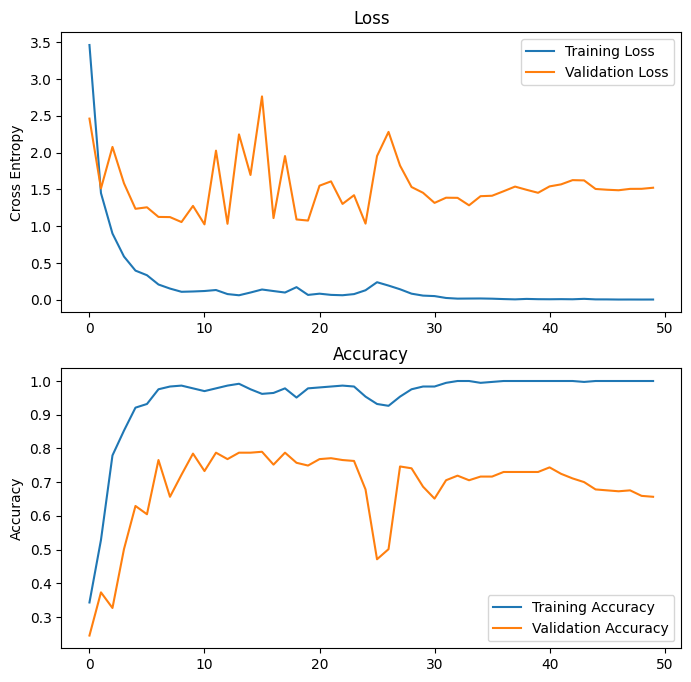

In [2]:
import os
import random
import numpy as np  
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time

# Define constants for the image size and batch size
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 32
DATA_DIR = "./data"
IMG_SHAPE = IMAGE_SIZE + (3,)

# Function to load dataset with an optional validation split
def load_dataset(data_directory, subset=None, validation_split=None, is_test=False):
    """Load images from directory and possibly split into subsets."""
    return keras.utils.image_dataset_from_directory(
        directory=data_directory,
        labels='inferred',
        label_mode='int',
        class_names=None,  # Automatically infer the class names
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        seed=42,
        validation_split=validation_split if not is_test else None,
        subset=subset if not is_test else None,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )

# Normalize the images by scaling pixel values to [0, 1]
normalization_layer = keras.layers.Rescaling(1./255)

# Apply normalization across datasets and ensure prefetching for performance
def normalize_dataset(ds, normalize=True):
    """Apply dataset transformations like normalization and prefetching."""
    if normalize:
        ds = ds.map(lambda x, y: (normalization_layer(x), y))
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = load_dataset(DATA_DIR, subset='training', validation_split=0.9)
val_ds = load_dataset(DATA_DIR, subset='validation', validation_split=0.1)
test_ds = load_dataset(DATA_DIR, is_test=True)

train_ds = normalize_dataset(train_ds)
val_ds = normalize_dataset(val_ds)
test_ds = normalize_dataset(test_ds, normalize=False)  # Optionally keep test data raw

print("Datasets are loaded and preprocessed.")


# Función para generar un nombre único basado en la fecha y hora
def unique_name(base_name):
    # Agrega un timestamp o un contador para asegurar nombres únicos
    return "{}_{}".format(base_name, int(time.time()))

# Build the model using a sequential API.
model = keras.Sequential([
    # First Convolutional Block
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE, name=unique_name('conv2d_1')),
    keras.layers.BatchNormalization(name=unique_name('batch_norm_1')),  # Batch normalization layer
    keras.layers.MaxPooling2D(2, 2, name=unique_name('max_pool_1')),
    
    # Second Convolutional Block
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name=unique_name('conv2d_2')),
    keras.layers.BatchNormalization(name=unique_name('batch_norm_2')),
    keras.layers.MaxPooling2D(2, 2, name=unique_name('max_pool_2')),
    
    # Third Convolutional Block
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name=unique_name('conv2d_3')),
    keras.layers.BatchNormalization(name=unique_name('batch_norm_3')),
    keras.layers.MaxPooling2D(2, 2, name=unique_name('max_pool_3')),
    
    # Fourth Convolutional Block
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name=unique_name('conv2d_4')),
    keras.layers.BatchNormalization(name=unique_name('batch_norm_4')),
    keras.layers.MaxPooling2D(2, 2, name=unique_name('max_pool_4')),
    
    # Dropout to prevent overfitting
    keras.layers.Dropout(0.5, name=unique_name('dropout_5')),
    
    # Flatten the output of the convolutions to pass to the Dense layer
    keras.layers.Flatten(name=unique_name('flatten_6')),
    
    # Dense layers for classification
    keras.layers.Dense(512, activation='relu', name=unique_name('dense_7')),
    keras.layers.BatchNormalization(name=unique_name('batch_norm_8')),
    keras.layers.Dense(5, activation='softmax', name=unique_name('dense_9'))  # Output layer with 5 classes
])

# Setup the optimizer, loss function, and metrics for the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Fit the model to the data
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

# Extract history for plotting
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss and accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()




# Test model

115/115 [==============================] - 21s 183ms/step - loss: 348.3299 - accuracy: 0.7114
Test Loss: 348.3299255371094
Test Accuracy: 0.7114441394805908


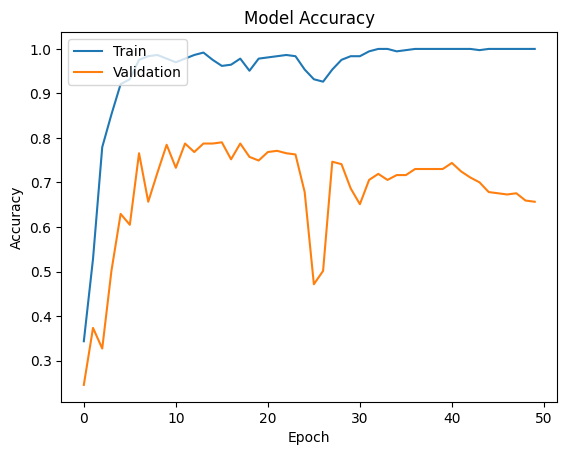

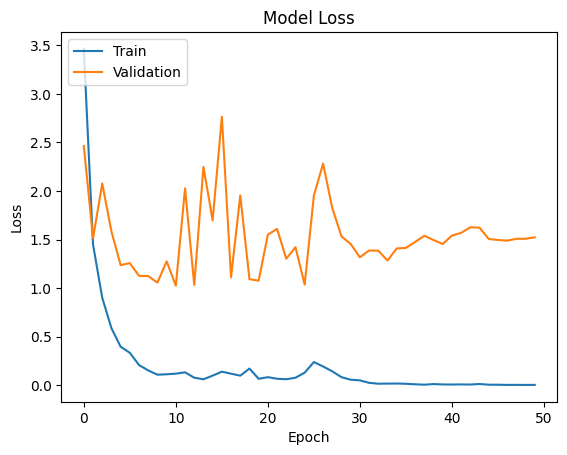

In [3]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save and export model

In [4]:
model.save('./models/flowers_model.keras')

In [5]:
model.save_weights('./models/flowers_model.weights.h5')

In [6]:
!tensorflowjs_converter --input_format=keras_saved_model --output_format=tfjs_layers_model ./models/flowers_model.keras ./models/flowers_js_model

/Users/montevideo/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Instructions for updating:
Colocations handled automatically by placer.
/Users/montevideo/code/FlowersDetection/FlowersDetection/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-04-26 19:02:31.126554: W tensorflow/c/c_api.cc:305] Operation '{name:'batch_norm_4_1714154023/moving_mean/Assign' id:258 op device:{requested: '', assigned: ''} def:{{{node batch_norm_4_1714154023/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_norm_4_1714154023/moving_mean, batch_norm_4_1714154023/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes